***CHÚ Ý***: Tìm hiêu xem số chiều của resnet với mỗi filter là bao nhiêu, liệu ảnh kích thước đầu vào đúng chưa, các layer làm gì, nhất là các layer cuối cùng

kiểm tra xem đã shuffle data sau mỗi epoch chưa

liệu có flatten quá sớm không

thử bỏ dropout, regu ở lớp conv, chỉ để ở FC vì:
* hiệu quả chưa đc kiểm chứng
* batchnorm đã làm phần nào regu rồi

tại sao model của keras không giảm loss đc?

tại sao model res11, res50 lại cho loss tệ hơn cái model tempt??????

mae vs mse

kiểm chứng: nhìn chung mình sẽ thêm layer/unit đến khi nào cái val loss ko thể bé hơn được nữa. Còn về L2 thì thực ra nó có hiệu ứng gần như early stopping, khi loss chạm đến cực tiểu thì mình dừng học ở early stop, cũng như tiếp tụ học ở L2 nhưng thy đổi của các tham số chỉ xoay quanh cá giá trị mà mình dừng ở early stopping thôi. Còn cái dropout hôm nọ tra thì có người nói nó giống ensemble hơn là regu

[callbacks](https://towardsdatascience.com/tensorflow-callbacks-how-to-monitor-neural-network-training-like-a-pro-f02cb4e477d0) model checkpoint, CSVLogger

test dataset

data augmentation



MAE/MSE/RMSE


chiến lược:


* Xác định trước xem train/val loss/accuracy trước và sau khi hiệu chỉnh là bao nhiêu. Quan trọng vì để xác định khi nào thì đã đủ overfit
* tạo 1 kiến trúc đơn giản.
 * đảm bảo nó overfit trên tập dữ liệu rất bé trước.
 * nếu không thể overfit trên tập dữ liệu lớn:
   * thử các chiến lực giảm learning rate khác nhau (coarse cho nhiều lr trước). Nếu không được:
   * dùng thuật toán tối ưu khác (coarse cho nhiều **tổ hợp** optimizer + lr trước): Adam, SGD, Adadelta (do có thể đang mắc ở các điểm saddle). Nếu không được:
   * thử kiến trúc phức tạp hơn

* Sau khi đảm bảo overfit trên toàn bộ tập dữ liệu rồi: thêm hiệu chỉnh/drop out.
 * đảm bảo nó overfit trên tập dữ liệu rất bé trước.
 * nếu bị underfit trên toàn tập dữ liệu:
   * thử giảm learning rate (coarse...). Nếu không được:
   * dùng các thuật toán tối ưu khác (coarse...). Nếu không được:
   * kiểm tra xem lambda có bị lớn quá không. Nếu không được:
   * thử kiến trúc khác phức tạp hơn



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import

In [2]:
!git clone https://github.com/LapTQ/facial_beauty_perception
%cd facial_beauty_perception/FBP5500/Images

Cloning into 'facial_beauty_perception'...
remote: Enumerating objects: 11462, done.
remote: Counting objects: 100% (11462/11462), done.
remote: Compressing objects: 100% (11447/11447), done.
remote: Total 11462 (delta 287), reused 11033 (delta 12), pack-reused 0
Receiving objects: 100% (11462/11462), 196.24 MiB | 19.32 MiB/s, done.
Resolving deltas: 100% (287/287), done.
Checking out files: 100% (11020/11020), done.
/content/facial_beauty_perception/FBP5500/Images


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
from sklearn.model_selection import train_test_split


from tensorflow.keras.preprocessing import image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization, Conv2D, Activation, Add, Input, Dense, ZeroPadding2D, Flatten, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
from keras.initializers import he_normal
from keras.regularizers import L1, L2
from keras.models import Model

import pathlib
import tempfile
import shutil

from IPython import display

from tensorflow.keras.optimizers import Adam, SGD, Adadelta, RMSprop, Nadam
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers


seed = 42

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

### Load images

In [5]:
#@title Choose hyper-parameter
image_size =  175#@param [224] {allow-input: true} {type:"integer"}

batch_size = 32 #@param [32, 64, 128, 256]

channels = "1" #@param [1, 3]

image_size = (image_size, image_size)
batch_size = int(batch_size)
channels = int(channels)

input_shape = image_size + (channels,)

scores_path = "https://github.com/LapTQ/facial_beauty_perception/raw/main/FBP5500/train_test_files/All_labels.csv"

scores_dataframe = pd.read_csv(
    scores_path,
    header=None,
    names=['file_name', 'score']
)

scores = scores_dataframe['score'].to_numpy().tolist()

print('batch input shape:', (batch_size,) + input_shape)

batch input shape: (32, 175, 175, 1)


count    5500.000000
mean        2.990891
std         0.688112
min         1.016667
25%         2.500000
50%         2.833333
75%         3.533333
max         4.750000
Name: score, dtype: float64


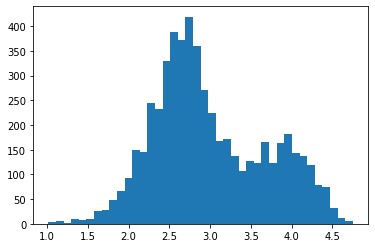

In [ ]:
print(scores_dataframe['score'].describe())

plt.hist(scores_dataframe['score'], bins=40)
plt.show()

In [ ]:
############################################# xem xét xóa đoạn code này
genders = [scores_dataframe['file_name'][index][1] for index in scores_dataframe.index]
genders = np.array(genders)
set_seed(seed)
np.random.shuffle(genders)

In [ ]:
############################################# xem xét xóa đoạn code này
images = []
for index in scores_dataframe.index:
    img = image.load_img(scores_dataframe['file_name'][index], target_size=image_size, color_mode="grayscale" if channels == 1 else 'rgb')
    img = image.img_to_array(img)
    images.append(img)

In [ ]:
############################################# xem xét xóa đoạn code này
images = np.array(images)
scores = np.array(scores)

set_seed(seed)
np.random.shuffle(images)
set_seed(seed)
np.random.shuffle(scores)

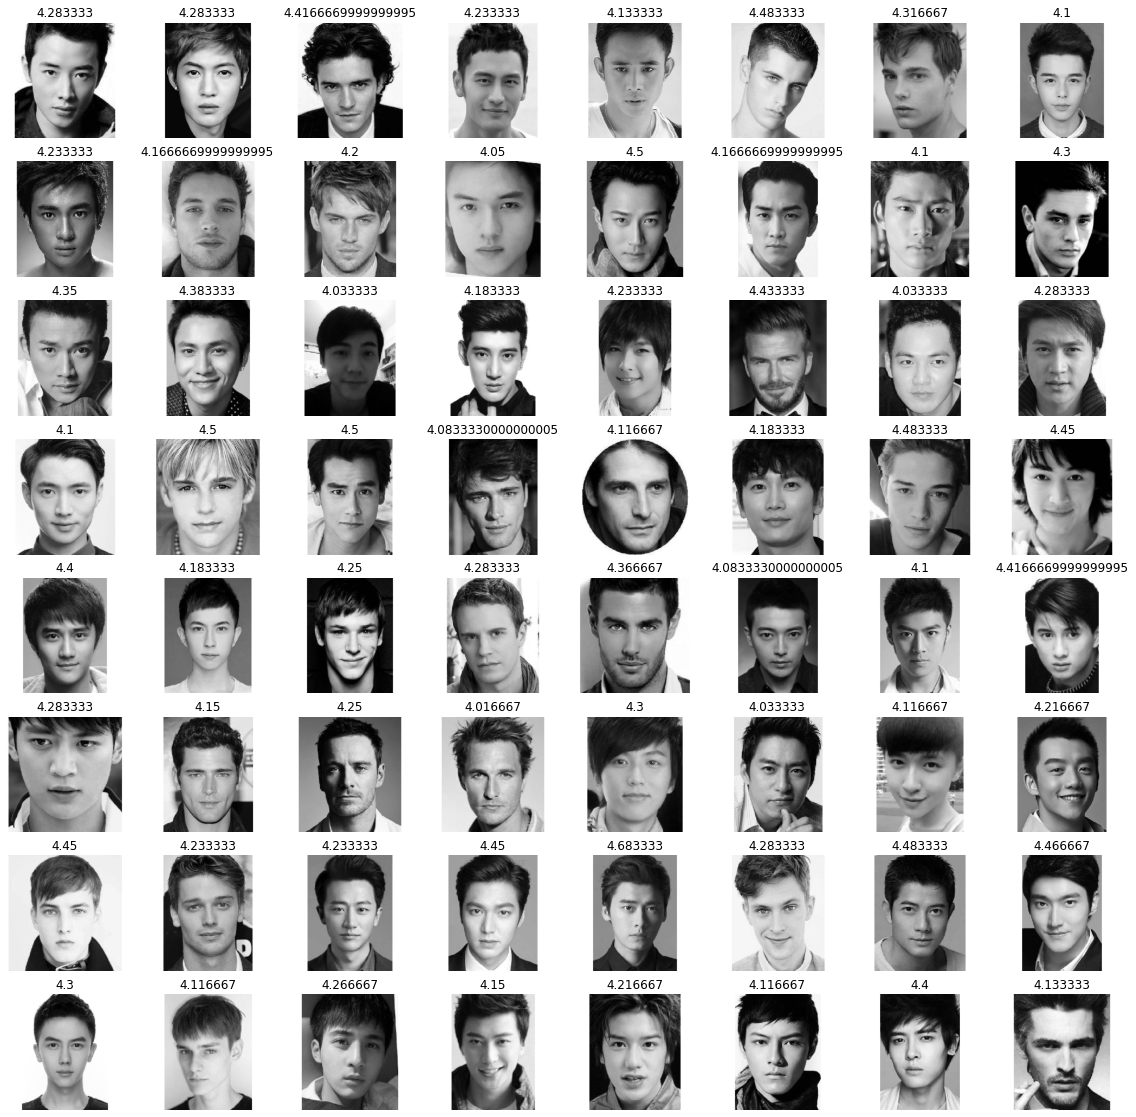

In [ ]:
#@title Show some images and their beauty score
group = '5' #@param [1, 2, 3, 4, 5]
n = 64 #@param {type:"integer"}
shift = 0 #@param {type:"integer"}
gender = 'Male' #@param ['Female', 'Male']

group = int(group)
gender = gender[0]

group = int(group)

def plot_faces(group, n, shift, gender):
    i = j = 0
    plt.figure(figsize=(20, 20))
    while i < 64:
        if shift + j < 5500 and group - 1 < scores[shift + j] <= group and genders[shift + j] == gender:
            ax = plt.subplot(8, 8, i + 1)
            if channels == 1:
                plt.imshow(np.squeeze(images[shift + j]), cmap='gray')
            else:
                plt.imshow(images[shift + j])
            plt.title(scores[shift + j])
            plt.axis("off")
            i += 1
        
        j += 1

plot_faces(group, n, shift, gender)

### Create dataset

In [6]:
# n_train = 4400
# v_validation = 1100
# buffer_size = 4400

In [7]:
# DEPRICATED 1

# images_ds = tf.data.Dataset.from_tensor_slices(images)
# scores_ds = tf.data.Dataset.from_tensor_slices(scores)

# x_train = images_ds.take(n_train)
# x_val = images_ds.skip(n_train)

# y_train = scores_ds.take(n_train)
# y_val = scores_ds.skip(n_train)

In [8]:
# DEPRICATED 1

# x_val_prefetch = x_val.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
# x_train_prefetch = x_train.cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# y_val_prefetch = y_val.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
# y_train_prefetch = y_train.cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [9]:
# ds = tf.data.Dataset.from_tensor_slices((images, scores))

# train_ds = ds.take(n_train)
# val_ds = ds.skip(n_train)

In [10]:
# steps_per_epoch = {'tiny': 5,
#                    'small': 27,
#                    'medium': 64,
#                    'large': 100,
#                    'all': n_train//batch_size}

In [11]:
# def get_dataset(batch_size, dataset_size='all'):
#     set_seed(seed)
#     if dataset_size == 'all':
#         return (train_ds.cache().shuffle(buffer_size, seed, reshuffle_each_iteration=True).repeat().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE),
#                 val_ds.cache().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
#                 )
#     else:
#         return (train_ds.take(steps_per_epoch[dataset_size]).cache().shuffle(buffer_size, seed, reshuffle_each_iteration=True).repeat().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE),
#                 val_ds.take(steps_per_epoch[dataset_size]).cache().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
#                 )

In [12]:
# def generator():
#     for index in train_scores_df.index:
#         img = image.load_img(train_scores_df['file_name'][index], target_size=image_size)#, color_mode="grayscale")
#         img = image.img_to_array(img)
#         yield img/255., train_scores_df['score'][index]

# train_ds = tf.data.Dataset.from_generator(
#     generator,
#     output_types=(tf.float32, tf.float32),
#     output_shapes=((*image_size, 3), tuple())
# ).cache().shuffle(buffer_size=5500, reshuffle_each_iteration=True).batch(64).prefetch(buffer_size=tf.data.AUTOTUNE)

# ################ chưa có cho tập rất bé


# train_ds.map(lambda x, y: (data_augmentation(x, training=True), y),
#              num_parallel_calls=tf.data.AUTOTUNE)
# # data_augmentation(train_ds)

In [13]:
#@title Choose validation size split ratio
test_size = 0.2 #@param {allow-input: true}

train_scores_df, val_scores_df = train_test_split(scores_dataframe, test_size=test_size, shuffle=True, random_state=seed)

print('%d images for training' % (len(train_scores_df)))
print('%d images for validation' % (len(val_scores_df)))

4400 images for training
1100 images for validation


In [14]:
def filename_to_img(filename, label):
    img_string = tf.io.read_file(filename)
    
    # Don't use tf.image.decode_image, or the output shape will be undefined
    img = tf.image.decode_jpeg(img_string, channels=channels)

    # This will convert to float values in [0, 1]
    # img = tf.image.convert_image_dtype(img, tf.float32)

    # img = tf.image.resize(img, image_size)

    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((train_scores_df['file_name'], train_scores_df['score']))
val_ds = tf.data.Dataset.from_tensor_slices((val_scores_df['file_name'], val_scores_df['score']))

train_ds = train_ds.map(filename_to_img, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(filename_to_img, num_parallel_calls=tf.data.AUTOTUNE)

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=5500)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=5500)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [15]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.Resizing(*image_size),
  tf.keras.layers.Rescaling(1./255), # use offset=-1 if wanted it to be [-1, 1]
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomContrast(0.5),
  tf.keras.layers.RandomZoom(0.08, 0.08),
  tf.keras.layers.RandomTranslation(0.2, 0.2)
])

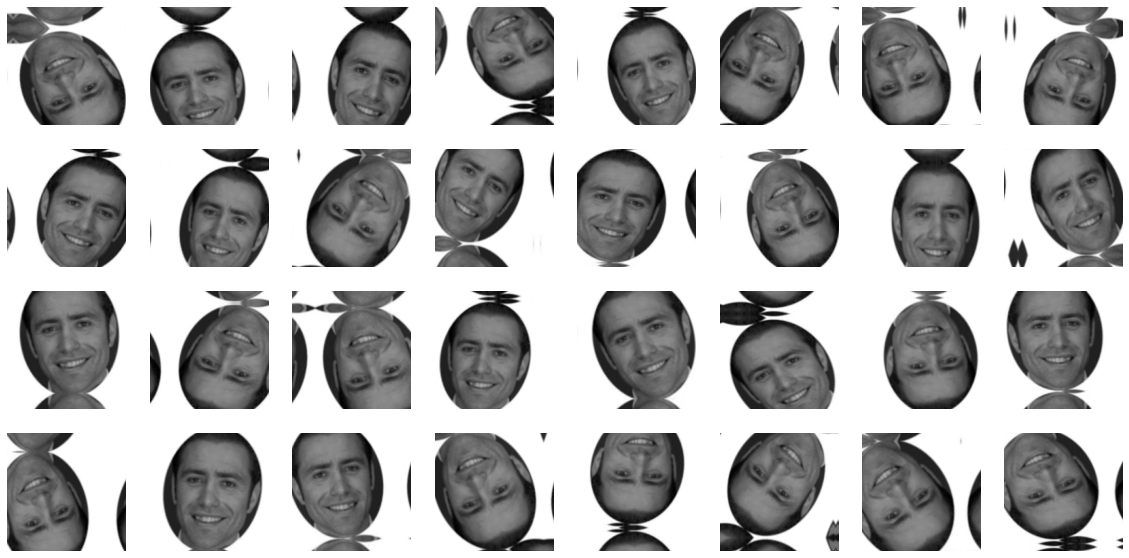

In [16]:
plt.figure(figsize=(20, 10))
for img, sco in train_ds.take(1):
    for i in range(32):
        augmented_image = data_augmentation(img)
        ax = plt.subplot(4, 8, i + 1)
        if channels == 1:
            plt.imshow(np.squeeze(augmented_image[0], axis=-1), cmap='gray')
        else:
            plt.imshow(augmented_image[0])
        plt.axis("off")

### Utilities

In [17]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [18]:
models = {}
lr_record = {}
epoch_record = {}
histories = {}

In [19]:
def remove_model(name):
    try:
        del models[name]
        del histories[name]
        del lr_record[name]
        del epoch_record[name]
    except:
        pass

In [20]:
############################### handle trường hợp tiny data

def train_model(name, optimizer, max_epochs, reduce_lr_patience, early_stop_patience, checkpoint_name, monitor='val_nonregu_mae'):

    print(name)

    # if dataset_size == 'all': steps_per_epoch['all'] = n_train//batch_size

    # train_data, validation_data = get_dataset(batch_size, dataset_size)

    callbacks = [
                 tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=reduce_lr_patience, verbose=1),
                 tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=early_stop_patience, verbose=1),
                #  tf.keras.callbacks.TensorBoard(logdir/name)
                ]

    if checkpoint_name is not None:
        callbacks.append(tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/checkpoint/{}.hdf5'.format(checkpoint_name), monitor=monitor, verbose=1, save_best_only=True))
    
    shutil.rmtree(logdir/name, ignore_errors=True)     

    new_model = True
    if name in histories.keys() and input("'{}' already exists. Override? [y/n] ".format(name)) != 'y':
        new_model = False
    
    set_seed(seed)

    if new_model:

        models[name].compile(
            optimizer=optimizer,
            loss='mean_absolute_error',
            metrics=[tf.keras.losses.MeanAbsoluteError(name='nonregu_mae')]
        )

        histories[name] = models[name].fit(
            train_ds,
            steps_per_epoch=train_ds.cardinality().numpy(),     ############### <----- numpy() to avoid error
            epochs=max_epochs,
            validation_data=val_ds,
            callbacks=callbacks,
            shuffle=True
        )

        epoch_record[name] = [histories[name].epoch[-1]]
        lr_record[name] = [optimizer.get_config()['learning_rate']]

    else:

        models[name].optimizer.learning_rate.assign(optimizer.get_config()['learning_rate'])

        cont_history = models[name].fit(
            train_ds, 
            steps_per_epoch=train_ds.cardinality().numpy(),     ############### <----- numpy() to avoid error
            epochs=max_epochs,     
            validation_data=val_ds,    
            callbacks=callbacks,
            initial_epoch=histories[name].epoch[-1] + 1,
            shuffle=True
        )

        epoch_record[name].append(cont_history.epoch[-1])
        lr_record[name].append(optimizer.get_config()['learning_rate'])
        histories[name].epoch += cont_history.epoch
        histories[name].history['loss'] += cont_history.history['loss']
        histories[name].history['val_loss'] += cont_history.history['val_loss']
        histories[name].history['nonregu_mae'] += cont_history.history['nonregu_mae']
        histories[name].history['val_nonregu_mae'] += cont_history.history['val_nonregu_mae']

    return name

In [21]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-s4wj7o5x
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-s4wj7o5x
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=155965 sha256=7f5d9996280a1be97acee331ff1ecdd2a8d8bf61a36378700c10addc650f93bf
  Stored in directory: /tmp/pip-ephem-wheel-cache-m1xqjjo5/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [22]:
plotter = tfdocs.plots.HistoryPlotter(
    metric = 'nonregu_mae',
    smoothing_std=10
)

In [23]:
def loss(model, x, y, training=False):
    mae = tf.keras.losses.MeanAbsoluteError()
    y_pred = model(x, training=training)
    return mae(y_true=y, y_pred=y_pred)

def grad(model, x, y):
    with tf.GradientTape() as tape:
        loss_value = loss(model, x, y, training=True)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [24]:
def plot_activations(model, img):
    """
    Arguments:
        model
        img -- numpy array of shape (height, width, channel)
    """
    activations = [model.layers[0](np.expand_dims(img, axis=0))]      # Input layer
    for layer in model.layers[1:13]:         # 14th layer not match input shape because of shortcut
        # print("Inputing shape: {} to {} with expected input shape: {}".format(activations[-1].shape, layer.name, layer.input_shape))
        activations.append(layer(activations[-1], training=False))

    # plot activation distribution
    plt.figure(figsize=(20, 10))
    for i in range(len(activations)):
        plt.subplot(2, 7, i + 1)
        plt.title(model.layers[i].name)
        plt.tight_layout()
        plt.hist(activations[i].numpy().reshape(-1,), bins=20)

In [25]:
def plot_layer_filter(name, layer=0):
    shape = models[name].layers[layer].get_weights()[0].shape
    figure_shape = (math.ceil(shape[-1]/16), 16)
    plt.figure(figsize=(4/3*figure_shape[1], 4/3*figure_shape[0]))
    for i in range(shape[-1]):
        plt.subplot(*figure_shape, i + 1)
        plt.imshow(models[name].layers[layer].get_weights()[0][...,0, i], cmap='gray')     # just plot the 1st channel of a filter volume in the layer
        plt.axis('off')
    plt.show()

In [26]:
def plot_layer_output(name, layer=0, image_index=0):
    outputs = [np.expand_dims(images[image_index], axis=0)]
    for i in range(len(models[name].layers)):
        outputs.append(models[name].layers[i](outputs[-1]))
    
    shape = outputs[layer + 1].shape    # plot each channel of that layer
    figure_shape = (math.ceil(shape[-1]/16), 16)
    plt.figure(figsize=(4/3*figure_shape[1], 4/3*figure_shape[0]))
    for i in range(shape[-1]):
        plt.subplot(*figure_shape, i + 1)
        plt.imshow(np.squeeze(outputs[layer + 1][..., i]), cmap='gray')
        plt.axis("off")
    plt.show()

### Testing

#### plot activation distribution

In [ ]:
model = ResNet11(input_shape)
plot_activations(model, images[1])

#### Xác định

Regu|Train loss| Test loss
-|-|-
có|0.01|0.05
không|0.001|

In [ ]:
keras.models.clone_model(models['ResNet50_Adam_lr_0.0005']).save('/content/drive/MyDrive/overfit_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/overfit_model/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
# models['ResNet50_Adam_lr_0.0005'] = tf.keras.models.load_model('/content/drive/MyDrive/overfit_model')

In [ ]:
# import pickle
# import sys
# sys.setrecursionlimit(15000)
# history_dict = {name: histories[name].history for name in histories.keys()}
# with open('/content/drive/MyDrive/histories', 'wb') as file_pi:
#         pickle.dump(history_dict, file_pi)
# history_dict = pickle.load(open('/content/drive/MyDrive/histories', 'rb'))

#### Thử mô hình tự tạo :((

In [ ]:
print(tf.keras.applications.ResNet50(include_top=False, input_shape=input_shape, weights=None).count_params())
print(tf.keras.applications.VGG16(include_top=False, input_shape=input_shape, weights=None).count_params())
print(tf.keras.applications.InceptionV3(include_top=False, input_shape=input_shape, weights=None).count_params())

tf.keras.applications.ResNet50(include_top=False, input_shape=input_shape, weights=None).summary()

In [ ]:
for img, sco in train_ds.take(1):
    print(img.shape)

(32, 350, 350, 1)


In [27]:
inputs = Input(shape=(None, None, None))
x = data_augmentation(inputs)
base_model = tf.keras.applications.ResNet50(include_top=False, input_shape=input_shape, weights=None)
x = base_model(x, training=False)
x = Flatten()(x)
# x = Dropout(0.5)(x)
# x = Dense(40, activation='relu')(x) ################ , kernel_regularizer=L2(1e-3)
# x = Dropout(0.5)(x)
outputs = Dense(1)(x) ############# , kernel_regularizer=L2(1e-3)
model = Model(inputs=inputs, outputs=outputs)
# model.summary()

models['1'] = model

In [55]:
train_model('1', SGD(learning_rate=1e-3, momentum=0.9, nesterov=True), max_epochs=50, reduce_lr_patience=3, early_stop_patience=10, checkpoint_name='checkpoint')

1
'1' already exists. Override? [y/n] 
Epoch 40/50
138/138 [==============================] - ETA: 0s - loss: 0.5198 - nonregu_mae: 0.5206
Epoch 00040: val_nonregu_mae improved from inf to 0.50441, saving model to /content/drive/MyDrive/checkpoint/checkpoint.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


138/138 [==============================] - 101s 720ms/step - loss: 0.5198 - nonregu_mae: 0.5206 - val_loss: 0.5028 - val_nonregu_mae: 0.5044 - lr: 1.0000e-08
Epoch 41/50
138/138 [==============================] - ETA: 0s - loss: 0.5201 - nonregu_mae: 0.5202
Epoch 00041: val_nonregu_mae improved from 0.50441 to 0.50300, saving model to /content/drive/MyDrive/checkpoint/checkpoint.hdf5
138/138 [==============================] - 98s 712ms/step - loss: 0.5201 - nonregu_mae: 0.5202 - val_loss: 0.5028 - val_nonregu_mae: 0.5030 - lr: 1.0000e-08
Epoch 42/50
138/138 [==============================] - ETA: 0s - loss: 0.5187 - nonregu_mae: 0.5191
Epoch 00042: val_nonregu_mae did not improve from 0.50300
138/138 [==============================] - 96s 693ms/step - loss: 0.5187 - nonregu_mae: 0.5191 - val_loss: 0.5028 - val_nonregu_mae: 0.5033 - lr: 1.0000e-08
Epoch 43/50
138/138 [==============================] - ETA: 0s - loss: 0.5194 - nonregu_mae: 0.5194
Epoch 00043: val_nonregu_mae improved fro

'1'

In [ ]:
inputs = Input(shape=(None, None, None))
x = data_augmentation(inputs)
base_model = tf.keras.applications.ResNet50(include_top=False, input_shape=input_shape, weights=None)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
# x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu',kernel_regularizer=L2(1e-4))(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu',kernel_regularizer=L2(1e-4))(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu',kernel_regularizer=L2(1e-4))(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu',kernel_regularizer=L2(1e-4))(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu',kernel_regularizer=L2(1e-4))(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu',kernel_regularizer=L2(1e-4))(x)
x = Dropout(0.5)(x)
outputs = Dense(1)(x) ############# , kernel_regularizer=L2(1e-3)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

In [28]:
models['2'] = Model(inputs=models['1'].input, outputs=models['1'].layers[-3].output)
models['2'].summary()

ValueError: ignored

In [71]:
models['1'].layers[-3].output

<KerasTensor: shape=(None, 6, 6, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

{'1': [0.001, 1.0000001e-08, 1e-08]}
{'1': [13, 38, 49]}


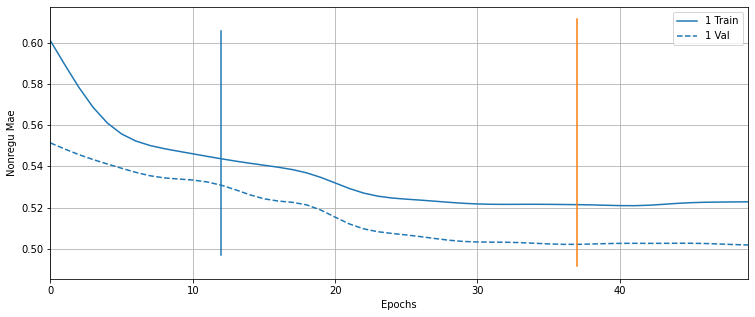

In [56]:
plt.figure(figsize=(12.5, 5))
plotter.plot(histories)
epoch_set = set()
for name in epoch_record.keys():
    epoch_set.update(set(epoch_record[name]))
epoch_set = sorted(list(epoch_set))
for i in range(len(epoch_set) - 1):
    plt.plot([epoch_set[i] - 1, epoch_set[i] - 1], plt.ylim())
# a = plt.xscale('log')
# plt.xlim([140, 170])
# plt.ylim([0.00665, 0.006725])
plt.xlabel('Epochs')
print(lr_record)
print(epoch_record)

In [ ]:
model.evaluate(val_ds)

35/35 [==============================] - 158s 4s/step - loss: 3.6922 - nonregu_mae: 2.8657


[3.6921935081481934, 2.865666389465332]

#### Thêm regu

In [ ]:
models['checkpoint'] = get_model_v2()

In [ ]:
models['checkpoint'].load_weights('/content/drive/MyDrive/checkpoint/checkpoint2.hdf5')

In [ ]:
plot_layer_filter('1', layer=2)

In [ ]:
list(enumerate(models['pretrained_model'].layers))

In [ ]:
plot_layer_output('pretrained_model', layer=2, image_index=0)

#### make sure can overfit

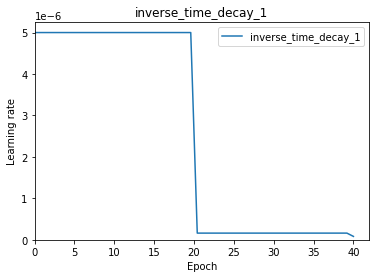

In [ ]:
inverse_time_decay_1 = InverseTimeDecay(
    initial_learning_rate=5e-6,
    decay_steps=steps_per_epoch*20,
    decay_rate=30,
    staircase=True,
    name='inverse_time_decay_1'
)

step = np.linspace(0, steps_per_epoch * max_epochs)

plot_learning_rate(step, inverse_time_decay_1)

### TensorBoard

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir {logdir}/lr

In [ ]:
validation_data = get_dataset(32)[1]
predictions = tf.data.Dataset.from_tensor_slices(np.squeeze(model.predict(validation_data))).batch(32)

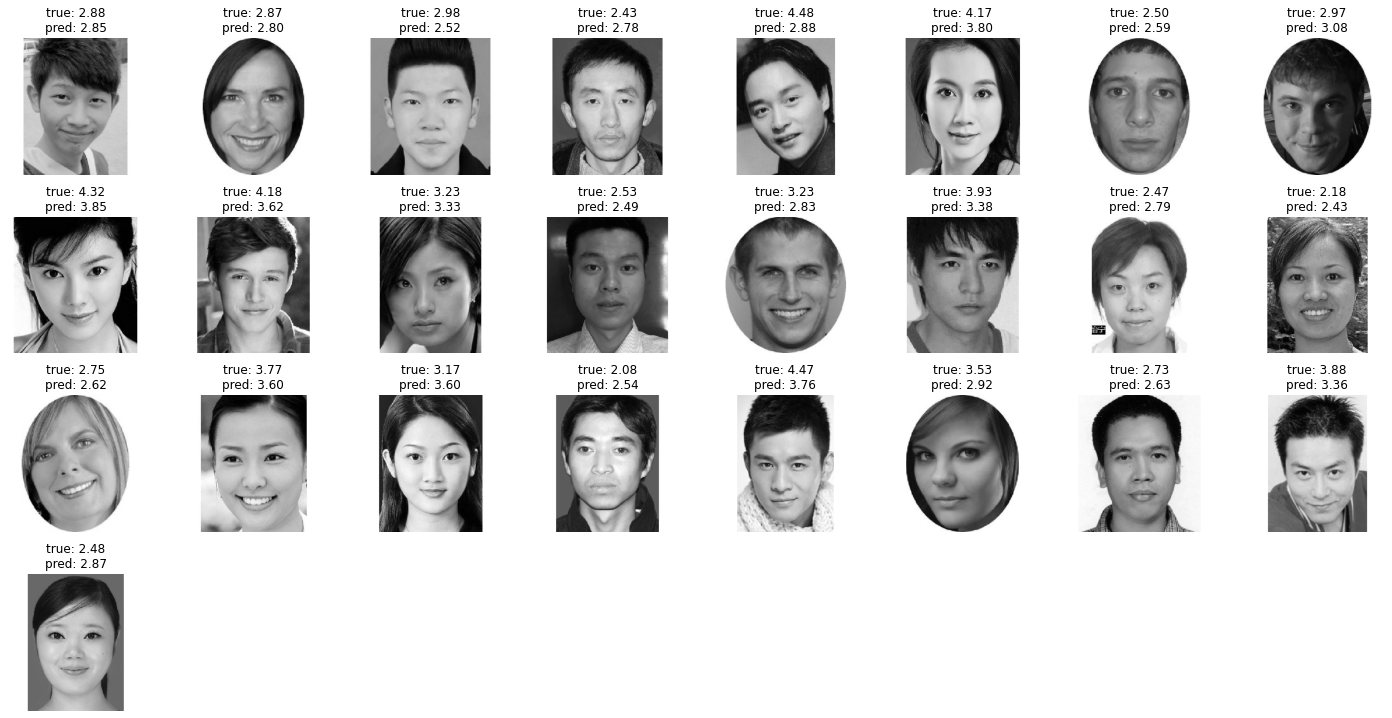

In [ ]:
plt.figure(figsize=(20, 20))
for imgs, true_scores in validation_data.take(1):
    for pred_scores in predictions.take(1):
        for i in range(25):
            ax = plt.subplot(8, 8, i + 1)
            plt.imshow(np.squeeze(imgs[i]), cmap='gray')
            plt.title('true: {:.2f}\npred: {:.2f}'.format(true_scores[i], pred_scores[i]))
            plt.tight_layout()
            plt.axis("off")